# 프로젝트

## 1. 크롤링

In [9]:
import openpyxl
import os
import time
import selenium
import codecs
import numpy as np
import warnings
warnings.simplefilter("ignore")

from selenium import webdriver
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import Chrome

import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import cm 
from matplotlib import font_manager, rc

colors = cm.get_cmap('Set2')(np.arange(5))
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

In [4]:
url = 'https://www.jejupassrent.com/home/main/main.do?&ACE_REF=adwords_g&ACE_KW=&gclid=Cj0KCQjwpdqDBhCSARIsAEUJ0hPXslg3iH3YCpB1DQqXOW6551DgNBYpE-jJkUKD8KmpyKbmqs0nRnoaAvFKEALw_wcB'

# 제주 렌트카 사이트 열기
options = webdriver.ChromeOptions()
options.add_argument('lang=ko_KR') 

browser = Chrome(options=options)
browser.get(url)

# 파일생성 
if not os.path.isdir('car_review_file'):
        os.mkdir('car_review_file')

(1) 데이터 수집 함수 정의

In [8]:
def data_crawling(top_num):
    try: 
        # 더 많은 후기 선택 
        review_link = browser.find_element_by_css_selector('div.title a') 
        review_link.click()
        time.sleep(1.0)
    
        # (분석 대상: 후기가 많은 회사 선정) 후기 많은 순 선정
        many_review = browser.find_elements_by_css_selector('li.bu-dot-item a')[1]
        many_review.click()
        time.sleep(1.0)
    
        # 각 회사별 후기 선택
        review_click = browser.find_elements_by_css_selector('div.head a')[top_num-1]
        review_click.send_keys(Keys.ENTER)
        time.sleep(1.0)
        
        # 각 회사마다 전체 reveiw 페이지를 확인위한 코드
        try:
            last_page = browser.find_element_by_css_selector('li.last a')
        except:
            last_page = browser.find_elements_by_css_selector('div.pagination ul li')[-1]
            
        last_page.send_keys(Keys.ENTER)
        page_range = int(browser.current_url.split('=')[-1])
        time.sleep(1.5)
        
        try:
            first_page = browser.find_element_by_css_selector('li.first a')
        except:
            first_page = browser.find_elements_by_css_selector('div.pagination ul li')[0]
            
        first_page.send_keys(Keys.ENTER)
        time.sleep(1.5)
        # 회사명 추출
        company = browser.find_element_by_css_selector('div#content h3').text
        
    except:
        print("오류 발생! 번호: " + str(top_num))
        print("오류명: ", ex)
        print("다시 시도 바랍니다.")
        
    else:
        # 데이터 저장할 엑셀 열기
        wb = openpyxl.Workbook()
        sheet = wb.active
        sheet.append(['Num', 'Company', 'Year', 'Car_type', 'Review', 'Kindness_score', 'Cleanliness_score', 'Convenience_score', 'Review_score'])

        num = 1   
    
        print(f"--------------------{company} 정보 수집시작--------------------")
        for page in range(1, page_range + 1):
        
            #시간 지연
            time.sleep(2.0)
            page_end_num = page % 10
            reviews = browser.find_elements_by_css_selector('div.text-wrap')
    
            for review in reviews:

                # 리뷰 점수
                try:
                    review_score = float(review.find_elements_by_css_selector('div.review-summary span.review-point')[0].text)
                except:
                    reivew_score = -1
    
                # 리뷰 점수 中 친절도
                try:
                    kindness_score = int(review.find_elements_by_css_selector('ul.review-point-detail dd')[0].text)
                except:
                    kindness_score = -1
        
                # 리뷰 점수 中 청결도
                try:
                    cleanliness_score = int(review.find_elements_by_css_selector('ul.review-point-detail dd')[1].text)
                except:
                    cleanliness_score = -1
    
                # 리뷰 점수 中 편의성
                try: 
                    convenience_score = int(review.find_elements_by_css_selector('ul.review-point-detail dd')[2].text)
                except: 
                    convenience_score = -1
    
                # 리뷰 내용
                try: 
                    review_text = review.find_elements_by_css_selector('p')[0].text.replace(',', ' ')
                except: 
                    review_text = '없음'
    
                # 리뷰 연도
                try:
                    review_year = review.find_elements_by_css_selector('ul li')[5].text.split('~')[0].split('.')[0]
                except: 
                    review_year = 0
                    
                # 대여 차량
                try:
                    rental_car = review.find_elements_by_css_selector('ul li')[3].text.split('(')[0].strip()
                except:
                    rental_car = '없음'
                    
                sheet.append([num, company, review_year, rental_car, review_text, kindness_score, cleanliness_score, convenience_score, review_score])
                num = num + 1
    
            browser.execute_script("window.scrollTo(0,document.body.scrollHeight)")
            time.sleep(6.0)
        
            # 5page마다 수집 정보 알려주기
            if ((page % 5) == 0):
                print(str(num-1) + "개 자료 수집완료(" + str(page)+"페이지)")
                time.sleep(1.5)
            elif page == page_range:
                print("총" +str(num-1) + "개 자료 수집완료(" + str(page)+"페이지)")
                time.sleep(1.5)
                break
            
            if page != page_range:
                if (page_end_num % 10) != 0:
                    page = browser.find_elements_by_css_selector('div.pagination ul li a')[(page_end_num + 1)]
                    page.send_keys(Keys.ENTER)
                    time.sleep(1.5)
                else: 
                    next_page = browser.find_element_by_css_selector('div.pagination ul li.next a')
                    next_page.send_keys(Keys.ENTER)
                    time.sleep(1.5)   
            
        #f.close()
        wb.close()
        wb.save(f'car_review_file\\{company}_xlsx파일.xlsx')
        print(f"--------------------{company} 정보 수집완료--------------------")
        time.sleep(1.0)
                 
        # 최초사이트 복귀
        menu_click =  browser.find_element_by_css_selector('div.navbar-brand a')
        menu_click.click()
        time.sleep(1.0)

(2) 데이터 불러오기

In [9]:
# 데이터 불러오기
def company_num(company_list_num):
    for num in company_list_num:
        data_crawling(num)  

In [10]:
company_num([1])

--------------------조아렌트카 정보 수집시작--------------------
100개 자료 수집완료(5페이지)
200개 자료 수집완료(10페이지)
300개 자료 수집완료(15페이지)
400개 자료 수집완료(20페이지)
500개 자료 수집완료(25페이지)
600개 자료 수집완료(30페이지)
700개 자료 수집완료(35페이지)
800개 자료 수집완료(40페이지)
900개 자료 수집완료(45페이지)
1000개 자료 수집완료(50페이지)
1100개 자료 수집완료(55페이지)
1200개 자료 수집완료(60페이지)
1300개 자료 수집완료(65페이지)
1400개 자료 수집완료(70페이지)
1500개 자료 수집완료(75페이지)
1600개 자료 수집완료(80페이지)
1700개 자료 수집완료(85페이지)
1800개 자료 수집완료(90페이지)
1900개 자료 수집완료(95페이지)
2000개 자료 수집완료(100페이지)
2100개 자료 수집완료(105페이지)
2200개 자료 수집완료(110페이지)
2300개 자료 수집완료(115페이지)
2400개 자료 수집완료(120페이지)
2500개 자료 수집완료(125페이지)
2600개 자료 수집완료(130페이지)
2700개 자료 수집완료(135페이지)
2800개 자료 수집완료(140페이지)
2900개 자료 수집완료(145페이지)
3000개 자료 수집완료(150페이지)
3100개 자료 수집완료(155페이지)
3200개 자료 수집완료(160페이지)
3300개 자료 수집완료(165페이지)
3400개 자료 수집완료(170페이지)
3500개 자료 수집완료(175페이지)
3600개 자료 수집완료(180페이지)
3700개 자료 수집완료(185페이지)
3800개 자료 수집완료(190페이지)
3900개 자료 수집완료(195페이지)
4000개 자료 수집완료(200페이지)
4100개 자료 수집완료(205페이지)
4200개 자료 수집완료(210페이지)
4300개 자료 수집완료(215페이지)
4400개 자료 수집완료(220페이지)
4500개 자

(3) 각 회사 데이터 합치기

In [34]:
import glob
import os

input_file = r'C:\Users\gby1349\python\텍스트 분석\car_review_file' 
output_file = r'C:\Users\gby1349\python\텍스트 분석\car_review_file\렌트카 전체데이터.xlsx' 

all_file_list = glob.glob(os.path.join(input_file, '*.xlsx'))
all_data = [] 

for file in all_file_list:
    df = pd.read_excel(file) 
    df = df.drop_duplicates(['Review'])  # 중복된 review를 한건의 데이터로 축소
    all_data.append(df)
    
combine_data = pd.concat(all_data, axis=0, ignore_index=True) # concat함수를 이용해서 리스트의 내용을 병합
combine_data.to_excel(output_file, index=False, encoding='utf-8')

In [2]:
# 데이터 불러오기 
import pandas as pd

data_path = "C:\\Users\\gby1349\\python\\텍스트 분석\\car_review_file\\"
data = pd.read_excel(data_path + '렌트카 전체데이터.xlsx')

# 열 삭제
data = data.drop(['Num'], axis = 1)

##  2. 전처리 

#### (0) EDA.1 - 리뷰 점수의 분포 및 히스토그램

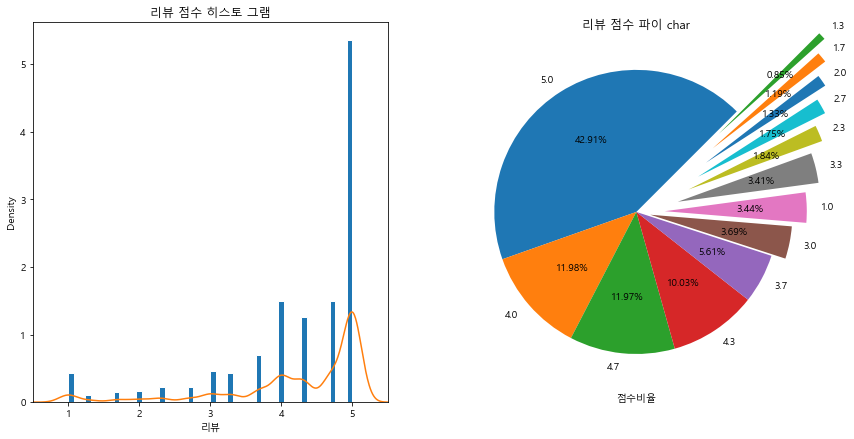

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14,7))

axes[0].hist(data['Review_score'], bins = 50, edgecolor='w', density = True)
axes[0].set_title('리뷰 점수 히스토 그램')
axes[0].set_xlabel('리뷰')
axes[0].set_ylabel('상대도수')
axes[0].set_xlim(0.5, 5.5, 0.1)

data['Review_score'].plot.density(ax=axes[0])

explod = [0,0,0,0,0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

axes[1].pie(data.Review_score.value_counts(),  autopct = "%.2f%%", explode = explod, 
            labels = data.Review_score.value_counts().index, startangle = 45)
axes[1].set_title('리뷰 점수 파이 char')
axes[1].set_xlabel('점수비율')

plt.show()

####  EDA.2 - 각 평가점수(청결도, 친절도, 편의성) 별 review_score 점수 분포

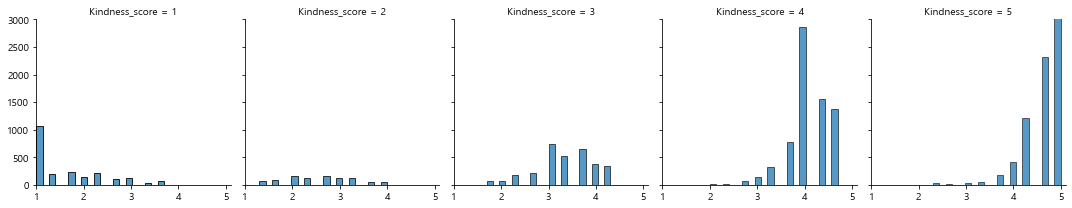

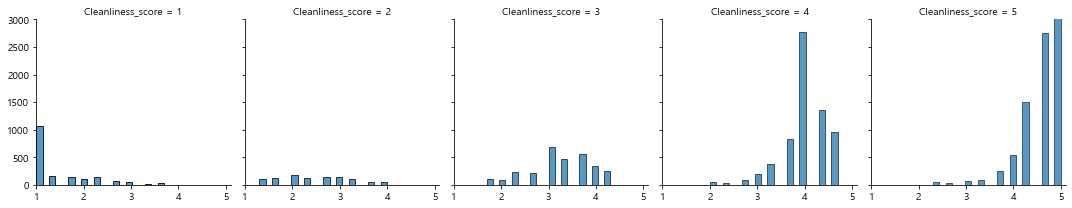

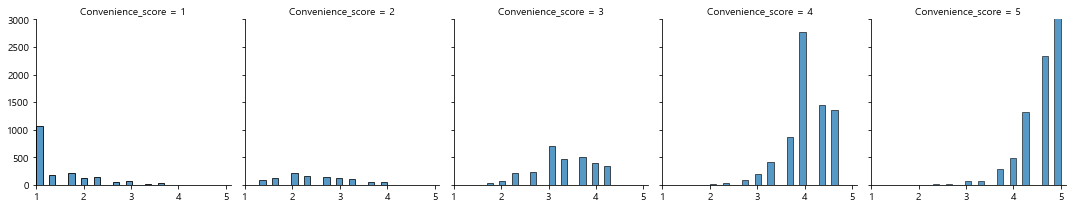

In [10]:
grid_1 = sns.FacetGrid(data, col =  'Kindness_score')
grid_1.map_dataframe(sns.histplot, x='Review_score', bins = 20)
grid_1.set(xlim = (1,5.1), ylim=(0,3000))
grid_1.tight_layout()
plt.show()

grid_2 = sns.FacetGrid(data, col = 'Cleanliness_score')
grid_2.map_dataframe(sns.histplot, x='Review_score', bins = 20)
grid_2.set(xlim = (1,5.1), ylim=(0,3000))
grid_2.tight_layout()
plt.show()

grid_3 = sns.FacetGrid(data, col = 'Convenience_score')
grid_3.map_dataframe(sns.histplot, x='Review_score',bins = 20)
grid_3.set(xlim = (1,5.1), ylim=(0,3000))
grid_3.tight_layout()
plt.show()

#### (1) 라벨 정의(감성분석)

긍정 리뷰 수 : 20084, 부정 리뷰수 : 4645


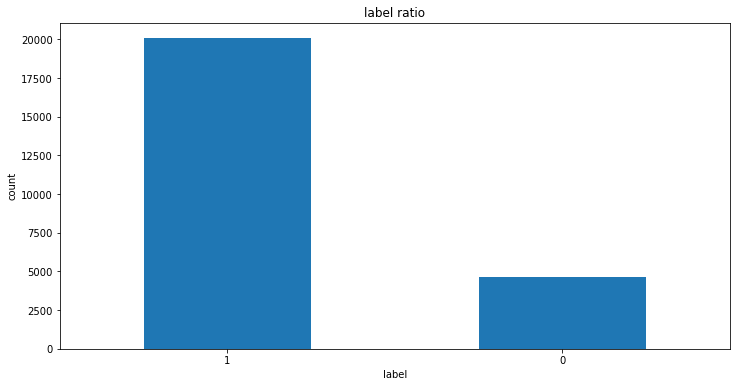

In [36]:
import numpy as np

# 여러 열에 조건들을 활용해야함으로써 인덱스를 가져옴
data = data.reset_index().rename(columns = {'index' : 'num'})
data['Label'] = np.nan

# 긍정 라벨 및 부정 라벨을 위한 인덱스 번호 리스트 추출
neg_label = list(data.query('Kindness_score <=2 or Cleanliness_score <=2 or Convenience_score <= 2 or Review_score <=2.7').num)
pos_label = list(data.query('Review_score > 4.0').num)
print("긍정 리뷰 수 : {}, 부정 리뷰 수 : {}".format(len(pos_label), len(neg_label)))
      
data['Label'] = data['num'].map(lambda x : 0 if x in neg_label else 1 if x in pos_label else -1)

# 긍정, 부정의 데이터만 추출
data = data.loc[data.Label != -1 ,:]

# 인덱스 번호 삭제
del data['num']

import matplotlib.pylab as plt

ax = data.Label.value_counts().plot.bar(rot = 0, figsize = (12,6))
ax.set_title('label ratio')
ax.set_xlabel('label')
ax.set_ylabel('count')
plt.show()

#### (2) undeersampling(class 불균형) 

In [37]:
desired_apriori=0.40 # 전체 데이터 만 건에 가까울 정도의 비율 설정

idx_0 = data[data.Label == 0].index
idx_1 = data[data.Label == 1].index

nb_0 = len(data.loc[idx_0])
nb_1 = len(data.loc[idx_1])

undersampling_rate = ((1-desired_apriori)*nb_0)/(nb_1*desired_apriori)
undersampled_nb_1 = int(undersampling_rate*nb_1)

print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=1 after undersampling: {}'.format(undersampled_nb_1))

Rate to undersample records with target=0: 0.34691794463254333
Number of records with target=1 after undersampling: 6967


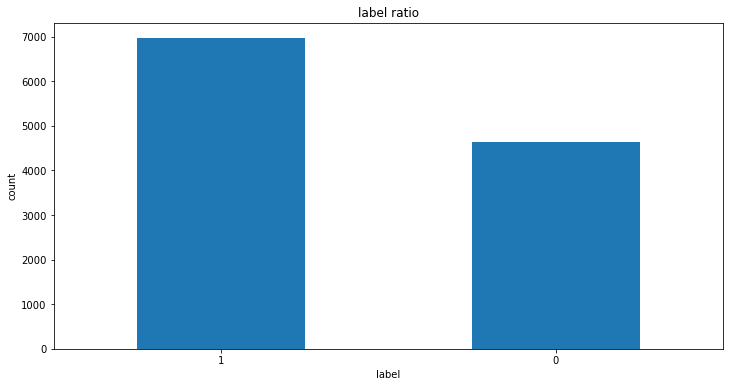

긍정 리뷰 개수: 6967, 부정 리뷰 개수: 4645
긍정 리뷰 비율: 60.00%


In [38]:
from sklearn.utils import shuffle

undersampled_idx = shuffle(idx_1, random_state=2000, n_samples=undersampled_nb_1)

idx_list = list(undersampled_idx) + list(idx_0)

data = data.loc[idx_list].reset_index(drop=True)

postive = data.loc[data.Label == 1, :].shape[0]
negative = data.loc[data.Label == 0, :].shape[0]

import matplotlib.pylab as plt

ax = data.Label.value_counts().plot.bar(rot = 0, figsize = (12,6))
ax.set_title('label ratio')
ax.set_xlabel('label')
ax.set_ylabel('count')
plt.show()

print("긍정 리뷰 개수: {}, 부정 리뷰 개수: {}".format(postive, negative))
print("긍정 리뷰 비율: {:.2f}%".format(postive / (postive + negative) *100))

#### (2) 자음, 모음만 있는 단어 제거 +  맞춤법 검사 

In [39]:
import re

consonant_vowel = re.compile(r'[ㄱ-ㅎㅏ-ㅣ]+')
data['Review'] = data['Review'].map(lambda x: consonant_vowel.sub('', str(x)))

In [7]:
url = 'https://www.daum.net/'

# 맞춤법
options = webdriver.ChromeOptions()

broswer = Chrome(options=options)
broswer.get(url)

keyword = broswer.find_element_by_css_selector('div.inner_search input#q')
keyword.send_keys('한글 맞춤법 검사기')

search =  broswer.find_element_by_css_selector('div.box_search button.ico_pctop.btn_search')
search.click()
time.sleep(1)

In [8]:
def check_grammar():
    total = data.Review.shape[0]
    wb = openpyxl.Workbook()
    sheet = wb.active
    sheet.append(['Num','Clean_review'])

    num = 1
    print(f"--------------------맞춤법 검사 중--------------------")

    for i in range(total):
        dirty_text = data.Review.iloc[i] # 검사할 정보 저장 
        length = len(dirty_text.encode('utf-8')) 
        
        try:
            if length <= 1900:
                time.sleep(0.5)
    
                check = broswer.find_element_by_css_selector('div.cont_grammar textarea#tfGrammar') # 맞춤법 검사할 리뷰 넣기 
                check.send_keys(dirty_text)
                time.sleep(0.5)

                button = broswer.find_element_by_css_selector('button#btnGrammarCheck span.inner') # 맞춤법 검사 버튼 누르기
                button.click()
                time.sleep(0.5)

                result = broswer.find_element_by_css_selector('div#contResult.cont_result')
                clear_text = result.text

                time.sleep(0.5)
                edit = broswer.find_element_by_css_selector('span.ico_rwd.ico_close_l')
                edit.click()
            else:
                clear_text = dirty_text
    
        except: 
            clear_text = dirty_text
            
        sheet.append([i, clear_text])
        if (num % 100) == 0:
            print("총 {}개 맞춤법 검사 완료. 진행률: {:.2f}%".format(num, num/total))

        if i == (total - 1):
            print("총 {}개 맞춤법 검사 완료. 진행률: {:.2f}%".format(num, num/total))

        num = num + 1

    wb.close()
    wb.save(f'car_review_file\\렌트카 데이터(sampling)_xlsx파일.xlsx')
    print(f"--------------------맞춤법 검사 완료--------------------")

In [9]:
check_grammar() 

--------------------맞춤법 검사 중--------------------
총 100개 맞춤법 검사 완료. 진행률: 0.01%
총 200개 맞춤법 검사 완료. 진행률: 0.02%
총 300개 맞춤법 검사 완료. 진행률: 0.03%
총 400개 맞춤법 검사 완료. 진행률: 0.03%
총 500개 맞춤법 검사 완료. 진행률: 0.04%
총 600개 맞춤법 검사 완료. 진행률: 0.05%
총 700개 맞춤법 검사 완료. 진행률: 0.06%
총 800개 맞춤법 검사 완료. 진행률: 0.07%
총 900개 맞춤법 검사 완료. 진행률: 0.08%
총 1000개 맞춤법 검사 완료. 진행률: 0.09%
총 1100개 맞춤법 검사 완료. 진행률: 0.09%
총 1200개 맞춤법 검사 완료. 진행률: 0.10%
총 1300개 맞춤법 검사 완료. 진행률: 0.11%
총 1400개 맞춤법 검사 완료. 진행률: 0.12%
총 1500개 맞춤법 검사 완료. 진행률: 0.13%
총 1600개 맞춤법 검사 완료. 진행률: 0.14%
총 1700개 맞춤법 검사 완료. 진행률: 0.15%
총 1800개 맞춤법 검사 완료. 진행률: 0.16%
총 1900개 맞춤법 검사 완료. 진행률: 0.16%
총 2000개 맞춤법 검사 완료. 진행률: 0.17%
총 2100개 맞춤법 검사 완료. 진행률: 0.18%
총 2200개 맞춤법 검사 완료. 진행률: 0.19%
총 2300개 맞춤법 검사 완료. 진행률: 0.20%
총 2400개 맞춤법 검사 완료. 진행률: 0.21%
총 2500개 맞춤법 검사 완료. 진행률: 0.22%
총 2600개 맞춤법 검사 완료. 진행률: 0.22%
총 2700개 맞춤법 검사 완료. 진행률: 0.23%
총 2800개 맞춤법 검사 완료. 진행률: 0.24%
총 2900개 맞춤법 검사 완료. 진행률: 0.25%
총 3000개 맞춤법 검사 완료. 진행률: 0.26%
총 3100개 맞춤법 검사 완료. 진행률: 0.27%
총 3200개 맞춤법 검사 완료. 진행률: 0.28%


- 맞춤법한 데이터 불러 와서 합치기

In [40]:
import pandas as pd

data_path = "C:\\Users\\gby1349\\python\\텍스트 분석\\car_review_file\\"
clear_data = pd.read_excel(data_path + '렌트카 데이터(sampling)_xlsx파일.xlsx')

# 데이터 합치기 위한 Num 생성
data = data.reset_index().rename(columns = {'index' : 'Num'})
data = pd.merge(data, clear_data, on = 'Num')

# 데이터 합친 이후 이전 review와 num제거 
del data['Num'] 
del data['Review']

# 컬럼명 변경 및 순서 변경
data = data.rename(columns = {'Clean_review' : 'Review'})
data = data[['Company', 'Year','Car_type','Review', 'Kindness_score', 'Cleanliness_score', 'Convenience_score' ,'Review_score', 'Label']]

#### (3) 기타 전처리

- ^^이모티콘: 웃음 이모티콘 치환
- 영어, 숫자, 특수문자 제거 
- 길이가 10 이하인 데이터 제거 
- Review 중 한 글자로만 이루어진 단어 삭제 
- 양쪽 공백 // 중복 공백 제거

In [41]:
import re

# 웃음표정(^^) 전처리
data['Review'] = data['Review'].map(lambda x: str(x).replace('^^', ' 웃음 이모티콘 '))

# 숫자, 문자(영어) 문자 제거
not_word = re.compile(r'[a-zA-Z0-9]+')
data['Review'] = data['Review'].map(lambda x: not_word.sub('', x))

# 특수 문자 제거 
exp_word = re.compile(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…]+')
data['Review'] = data['Review'].map(lambda x: exp_word.sub('', x))

# 자음, 모음만 이루어진 문자 제거 
consonant_vowel = re.compile(r'[ㄱ-ㅎㅏ-ㅣ]+')
data['Review'] = data['Review'].map(lambda x: consonant_vowel.sub('', x))

# review 길이가 10 미만인 데이터 삭제
data['Review'] = data['Review'].agg(lambda x: '' if len(x) <= 10 else x)
data['Review'].replace('', np.nan, inplace=True)  # 공백은 Null 값으로 변경

data= data.dropna(how='any') # Null 값 제거

# 한 글자 단어 삭제
shortword = re.compile(r'\W*\b\w{1}\b')
data['Review'] = data['Review'].map(lambda x: shortword.sub('', x))
# 2개 이상의 공백을 1개로 변환
data['Review'] = data['Review'].map(lambda x: re.sub(' +', ' ', x))

# 양쪽 공배 제거 
data['Review'] = data['Review'].agg(lambda x: x.strip())

In [41]:
data['Review'].replace('', np.nan, inplace=True)  # 공백은 Null 값으로 변경
data= data.dropna(how='any') # Null 값 제거

### 데이터 저장

In [ ]:
output_file = r'C:\Users\gby1349\python\텍스트 분석\리뷰데이터.xlsx' 
data.to_excel(output_file, index=False, encoding='utf-8')